In [ ]:

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import WeightedRandomSampler
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split





# 2. Graph Definition
joints = ['PELVIS', 'SPINE_NAVAL', 'SPINE_CHEST', 'NECK', 'CLAVICLE_LEFT', 'SHOULDER_LEFT',
          'ELBOW_LEFT', 'WRIST_LEFT', 'HAND_LEFT', 'HANDTIP_LEFT', 'THUMB_LEFT',
          'CLAVICLE_RIGHT', 'SHOULDER_RIGHT', 'ELBOW_RIGHT', 'WRIST_RIGHT', 'HAND_RIGHT',
          'HANDTIP_RIGHT', 'THUMB_RIGHT', 'HIP_LEFT', 'KNEE_LEFT', 'ANKLE_LEFT',
          'FOOT_LEFT', 'HIP_RIGHT', 'KNEE_RIGHT', 'ANKLE_RIGHT', 'FOOT_RIGHT',
          'HEAD', 'NOSE', 'EYE_LEFT', 'EAR_LEFT', 'EYE_RIGHT', 'EAR_RIGHT']

edges = [('PELVIS', 'SPINE_NAVAL'), ('SPINE_NAVAL', 'SPINE_CHEST'), ('SPINE_CHEST', 'NECK'),
         ('NECK', 'HEAD'), ('SPINE_CHEST', 'CLAVICLE_LEFT'), ('CLAVICLE_LEFT', 'SHOULDER_LEFT'),
         ('SHOULDER_LEFT', 'ELBOW_LEFT'), ('ELBOW_LEFT', 'WRIST_LEFT'), ('WRIST_LEFT', 'HAND_LEFT'),
         ('HAND_LEFT', 'HANDTIP_LEFT'), ('WRIST_LEFT', 'THUMB_LEFT'), ('SPINE_CHEST', 'CLAVICLE_RIGHT'),
         ('CLAVICLE_RIGHT', 'SHOULDER_RIGHT'), ('SHOULDER_RIGHT', 'ELBOW_RIGHT'), ('ELBOW_RIGHT', 'WRIST_RIGHT'),
         ('WRIST_RIGHT', 'HAND_RIGHT'), ('HAND_RIGHT', 'HANDTIP_RIGHT'), ('WRIST_RIGHT', 'THUMB_RIGHT'),
         ('PELVIS', 'HIP_LEFT'), ('HIP_LEFT', 'KNEE_LEFT'), ('KNEE_LEFT', 'ANKLE_LEFT'),
         ('ANKLE_LEFT', 'FOOT_LEFT'), ('PELVIS', 'HIP_RIGHT'), ('HIP_RIGHT', 'KNEE_RIGHT'),
         ('KNEE_RIGHT', 'ANKLE_RIGHT'), ('ANKLE_RIGHT', 'FOOT_RIGHT'),
         ('HEAD', 'NOSE'), ('HEAD','EYE_LEFT'), ('HEAD', 'EYE_RIGHT'), ('HEAD', 'EAR_LEFT'), ('HEAD', 'EAR_RIGHT')]



joint_to_idx = {joint: idx for idx, joint in enumerate(joints)}
edge_index = torch.tensor([[joint_to_idx[src], joint_to_idx[dst]] for src, dst in edges] +
                          [[joint_to_idx[dst], joint_to_idx[src]] for src, dst in edges],
                          dtype=torch.long).t()




# 3. Dataset
class SkeletonDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.data = df
        self.num_nodes = len(joints)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        node_features = [[row[f'{j}_X'], row[f'{j}_Y'], row[f'{j}_Z'], row['t_uniform']] for j in joints]
        x = torch.tensor(node_features, dtype=torch.float)
        y = torch.tensor(row['QoR_class'], dtype=torch.float)
        return Data(x=x, edge_index=edge_index, y=y)
    



# Load dataset
data_path =  r"D:\Data\NYC\KINZ\KINECT_ACC_dataset_with_qor15_2025-05-27_14-29PM.csv"
dataframe = pd.read_csv(data_path)
dataframe = dataframe[dataframe['walking_speed'] == "Fast"]
dataframe = dataframe[dataframe['QoR_class'].isin([0, 1])].copy()





df = dataframe

# Step 1: Create a patient-level table with QoR_class
patient_qor = df[['patientID', 'QoR_class']].drop_duplicates(subset='patientID')

# Step 2: Stratified patient-wise split
train_patients, test_patients = train_test_split(
    patient_qor['patientID'],
    test_size=0.2,
    stratify=patient_qor['QoR_class'],
    random_state=42
)

# Step 3: Create train/test splits of the full DataFrame
df_train = df[df['patientID'].isin(train_patients)].reset_index(drop=True)
df_test = df[df['patientID'].isin(test_patients)].reset_index(drop=True)

# Step 4: Check class balance
print("Train QoR_class distribution:")
print(df_train[['patientID', 'QoR_class']].drop_duplicates()['QoR_class'].value_counts())

print("\nTest QoR_class distribution:")
print(df_test[['patientID', 'QoR_class']].drop_duplicates()['QoR_class'].value_counts())






dataset = SkeletonDataset(df_train)

# 4. Random split
full_dataset = SkeletonDataset(dataframe.dropna(subset=['QoR_class']))
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

# 5. Weighted Sampling
train_indices = train_dataset.indices if isinstance(train_dataset, torch.utils.data.Subset) else list(range(len(train_dataset)))
train_df = dataframe.iloc[train_indices].reset_index(drop=True)
train_df = train_df.dropna(subset=['QoR_class'])
class_counts = train_df['QoR_class'].value_counts().sort_index().to_numpy()
class_weights = 1. / class_counts
sample_weights = [class_weights[int(label)] for label in train_df['QoR_class']]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)


# 6. Dataloaders
train_loader = DataLoader(train_dataset, batch_size=8, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)



# 7. Model
class HybridSTGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes):
        super().__init__()
        self.gcn1 = GCNConv(in_channels, hidden_channels)
        self.gcn2 = GCNConv(hidden_channels, hidden_channels)
        self.temporal_conv1 = nn.Conv1d(hidden_channels, hidden_channels, kernel_size=3, padding=1)
        self.lstm = nn.LSTM(hidden_channels, hidden_channels, batch_first=True)
        self.fc = nn.Linear(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        batch = getattr(data, 'batch', None)
        x = F.relu(self.gcn1(x, edge_index))
        x = F.relu(self.gcn2(x, edge_index))
        batch_size = batch.max().item() + 1 if batch is not None else 1
        num_nodes = x.size(0) // batch_size
        x = x.view(batch_size, num_nodes, -1).permute(0, 2, 1)
        x = F.relu(self.temporal_conv1(x)).permute(0, 2, 1)
        x, _ = self.lstm(x)
        x = x.mean(dim=1)
        return self.fc(x).squeeze()




# 8. Training Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HybridSTGCN(in_channels=4, hidden_channels=128, num_classes=1).to(device)
pos_weight = torch.tensor([class_weights[0] / class_weights[1]]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-4)




class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.005):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.best_model = None

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model = model.state_dict()
        else:
            self.counter += 1
            if self.counter >= self.patience:
                if self.best_model is not None:
                    model.load_state_dict(self.best_model)
                return True
        return False




# 9. Training Loop
num_epochs = 5
train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []
early_stopping = EarlyStopping()

for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        y = data.y.to(device).float()
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
        correct += ((out >= 0.5) == y).sum().item()
        total += data.num_graphs
    train_loss = total_loss / len(train_loader.dataset)
    train_acc = correct / total

    model.eval()
    total_loss, correct, total, all_preds, all_labels = 0, 0, 0, [], []
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            out = model(data)
            y = data.y.to(device).float()
            loss = criterion(out, y)
            total_loss += loss.item() * data.num_graphs
            pred = (torch.sigmoid(out) >= 0.5).float()
            correct += (pred == y).sum().item()
            total += data.num_graphs
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    test_loss = total_loss / len(test_loader.dataset)
    test_acc = correct / total
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch:03d}/{num_epochs} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Test Loss: {test_loss:.4f}, Acc: {test_acc:.4f}")

    if early_stopping(test_loss, model):
        print("Early stopping triggered.")
        break



# 10. Final Evaluation
accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
roc_auc = roc_auc_score(all_labels, all_preds)
tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
specificity = tn / (tn + fp)




print(f"Final Test Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=['Good (0)', 'Not Good (1)']))



# 11. Save Model + Stats
now = datetime.now().strftime("%Y%m%d_%H%M%S")
torch.save(model.state_dict(), f"QOR_hybrid_stgcn_model_{now}.pth")
with open(f"QOR_hybrid_stgcn_model_statistics_{now}.pkl", 'wb') as f:
    pickle.dump({
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_accuracies': train_accuracies,
        'test_accuracies': test_accuracies,
        'final_metrics': {
            'accuracy': accuracy,
            'f1_score': f1,
            'recall': recall,
            'precision': precision,
            'specificity': specificity,
            'roc_auc': roc_auc
        }
    }, f)
print("Model and statistics saved.")


C:\Users\user\AppData\Local\Temp\ipykernel_28092\3585398802.py:73: DtypeWarning: Columns (108,112,113,117,151,154,161,162,164,169,180,185,198,221,228,264,267,269,270,306,307,310,311,314,315,318,319,322,323,326,328,330,331,334,335,338,339,342,343,346,348,350,352,354,356,358,362,363,393,403,404,406,418,423,430,433,436,439,444) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframe = pd.read_csv(data_path)


Train QoR_class distribution:
QoR_class
0.0    33
1.0    26
Name: count, dtype: int64

Test QoR_class distribution:
QoR_class
0.0    9
1.0    6
Name: count, dtype: int64
Epoch 001/5 | Train Loss: 0.5806, Acc: 0.5190 | Test Loss: 0.5813, Acc: 0.5900
Epoch 002/5 | Train Loss: 0.5608, Acc: 0.5489 | Test Loss: 0.5533, Acc: 0.6037
Epoch 003/5 | Train Loss: 0.5453, Acc: 0.5582 | Test Loss: 0.5509, Acc: 0.6453
Epoch 004/5 | Train Loss: 0.5227, Acc: 0.5793 | Test Loss: 0.5112, Acc: 0.6801
Epoch 005/5 | Train Loss: 0.5027, Acc: 0.5955 | Test Loss: 0.4929, Acc: 0.6949
Final Test Accuracy: 0.6949
F1 Score: 0.6355
Recall: 0.6289
Precision: 0.6423
Specificity: 0.7433
AUC-ROC: 0.6861

Classification Report:

              precision    recall  f1-score   support

    Good (0)       0.73      0.74      0.74      4769
Not Good (1)       0.64      0.63      0.64      3495

    accuracy                           0.69      8264
   macro avg       0.69      0.69      0.69      8264
weighted avg       0.69 

# Patient wise Testing Data Report

In [2]:
# 1. Create test dataset from df_test
test_dataset_by_patient = SkeletonDataset(df_test)

# 2. Prepare DataLoader (no sampler)
test_loader_by_patient = DataLoader(test_dataset_by_patient, batch_size=1, shuffle=False)

# 3. Collect predictions by patient
from collections import defaultdict

model.eval()
patient_preds = defaultdict(list)
patient_labels = {}

with torch.no_grad():
    for i, data in enumerate(test_loader_by_patient):
        data = data.to(device)
        output = model(data)
        prob = torch.sigmoid(output).item()
        pred_class = 1 if prob >= 0.5 else 0

        patient_id = df_test.iloc[i]['patientID']
        true_class = int(df_test.iloc[i]['QoR_class'])

        patient_preds[patient_id].append(pred_class)
        patient_labels[patient_id] = true_class

# 4. Aggregate to per-patient report
report = []

for pid, preds in patient_preds.items():
    true_class = patient_labels[pid]
    total = len(preds)
    correct = sum([1 if p == true_class else 0 for p in preds])
    acc = correct / total
    final_prediction = 1 if np.mean(preds) >= 0.5 else 0  # majority via mean
    report.append({
        'patientID': pid,
        'actual_class': true_class,
        'predicted_class': final_prediction,
        'num_frames': total,
        'correct_predictions': correct,
        'accuracy_within_patient': acc
    })

# 5. Create DataFrame
patient_report_df = pd.DataFrame(report)

# 6. Summary Stats
print("Patient-level classification report:")
print("\nOverall patient-level accuracy:",
      (patient_report_df['actual_class'] == patient_report_df['predicted_class']).mean())
patient_report_df.head(-1)


Patient-level classification report:

Overall patient-level accuracy: 0.8


,patientID,actual_class,predicted_class,num_frames,correct_predictions,accuracy_within_patient
0,009-TB,1,1,862,729,0.845708
1,012-JM,0,1,589,125,0.212224
2,018-OS,0,0,266,149,0.560150
3,022-ND,1,0,250,1,0.004000
4,024-PO,1,1,294,182,0.619048
5,032-GB,0,0,392,247,0.630102
6,033-JF,1,1,581,337,0.580034
7,041-JL,0,0,77,66,0.857143
8,044-MS,1,1,633,464,0.733017
9,049-RL,0,1,260,130,0.500000


# Patient wise Training Data Report

In [3]:
# 1. Create test dataset from df_test
test_dataset_by_patient = SkeletonDataset(df_train)

# 2. Prepare DataLoader (no sampler)
test_loader_by_patient = DataLoader(test_dataset_by_patient, batch_size=1, shuffle=False)

# 3. Collect predictions by patient
from collections import defaultdict

model.eval()
patient_preds = defaultdict(list)
patient_labels = {}

with torch.no_grad():
    for i, data in enumerate(test_loader_by_patient):
        data = data.to(device)
        output = model(data)
        prob = torch.sigmoid(output).item()
        pred_class = 1 if prob >= 0.5 else 0

        patient_id = df_train.iloc[i]['patientID']
        true_class = int(df_train.iloc[i]['QoR_class'])

        patient_preds[patient_id].append(pred_class)
        patient_labels[patient_id] = true_class

# 4. Aggregate to per-patient report
report = []

for pid, preds in patient_preds.items():
    true_class = patient_labels[pid]
    total = len(preds)
    correct = sum([1 if p == true_class else 0 for p in preds])
    acc = correct / total
    final_prediction = 1 if np.mean(preds) >= 0.5 else 0  # majority via mean
    report.append({
        'patientID': pid,
        'actual_class': true_class,
        'predicted_class': final_prediction,
        'num_frames': total,
        'correct_predictions': correct,
        'accuracy_within_patient': acc
    })

# 5. Create DataFrame
patient_report_df = pd.DataFrame(report)

# 6. Summary Stats
print("Patient-level classification report:")
print("\nOverall patient-level accuracy:",
      (patient_report_df['actual_class'] == patient_report_df['predicted_class']).mean())
patient_report_df.head(-1)


Patient-level classification report:

Overall patient-level accuracy: 0.711864406779661


,patientID,actual_class,predicted_class,num_frames,correct_predictions,accuracy_within_patient
0,001-LO,1,1,959,959,1.000000
1,002-RJ,1,1,924,808,0.874459
2,003-RM,0,0,749,391,0.522029
3,004-MF,0,0,771,770,0.998703
4,005-GP,0,1,172,78,0.453488
5,006-TR,1,0,192,60,0.312500
6,007-LI,0,1,394,92,0.233503
7,008-BJ,0,1,714,227,0.317927
8,010-RA,0,1,394,130,0.329949
9,011-CB,0,0,392,240,0.612245


# Evaluation

In [4]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, confusion_matrix, classification_report

def evaluate_patient_level(df, model, device, name='Set'):
    model.eval()
    patient_ids = df['patientID'].unique()
    patient_results = []

    for pid in patient_ids:
        patient_data = df[df['patientID'] == pid].reset_index(drop=True)
        dataset = SkeletonDataset(patient_data)
        loader = DataLoader(dataset, batch_size=1, shuffle=False)

        all_probs = []
        true_label = int(patient_data['QoR_class'].iloc[0])

        with torch.no_grad():
            for sample in loader:
                sample = sample.to(device)
                out = model(sample)
                prob = torch.sigmoid(out).item()
                all_probs.append(prob)

        avg_prob = np.mean(all_probs)
        predicted_label = 1 if avg_prob >= 0.5 else 0

        patient_results.append({
            'patientID': pid,
            'actual_class': true_label,
            'predicted_class': predicted_label,
            'avg_probability': avg_prob
        })

    # Create DataFrame
    result_df = pd.DataFrame(patient_results)

    # Compute metrics
    y_true = result_df['actual_class']
    y_pred = result_df['predicted_class']
    y_prob = result_df['avg_probability']

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)

    print(f"\n📊 Patient-level Evaluation on {name}:")
    print(f"Accuracy    : {acc:.4f}")
    print(f"F1 Score    : {f1:.4f}")
    print(f"Recall      : {recall:.4f}")
    print(f"Precision   : {precision:.4f}")
    print(f"Specificity : {specificity:.4f}")
    print(f"AUC-ROC     : {auc:.4f}")
    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=['Good (0)', 'Not Good (1)']))

    return result_df



# Evaluate train set
train_patient_report = evaluate_patient_level(df_train, model, device, name='Train Set')

# Evaluate test set
test_patient_report = evaluate_patient_level(df_test, model, device, name='Test Set')



📊 Patient-level Evaluation on Train Set:
Accuracy    : 0.6949
F1 Score    : 0.6250
Recall      : 0.5769
Precision   : 0.6818
Specificity : 0.7879
AUC-ROC     : 0.7762

Classification Report:

              precision    recall  f1-score   support

    Good (0)       0.70      0.79      0.74        33
Not Good (1)       0.68      0.58      0.62        26

    accuracy                           0.69        59
   macro avg       0.69      0.68      0.68        59
weighted avg       0.69      0.69      0.69        59


📊 Patient-level Evaluation on Test Set:
Accuracy    : 0.8000
F1 Score    : 0.7692
Recall      : 0.8333
Precision   : 0.7143
Specificity : 0.7778
AUC-ROC     : 0.8333

Classification Report:

              precision    recall  f1-score   support

    Good (0)       0.88      0.78      0.82         9
Not Good (1)       0.71      0.83      0.77         6

    accuracy                           0.80        15
   macro avg       0.79      0.81      0.80        15
weighted avg    

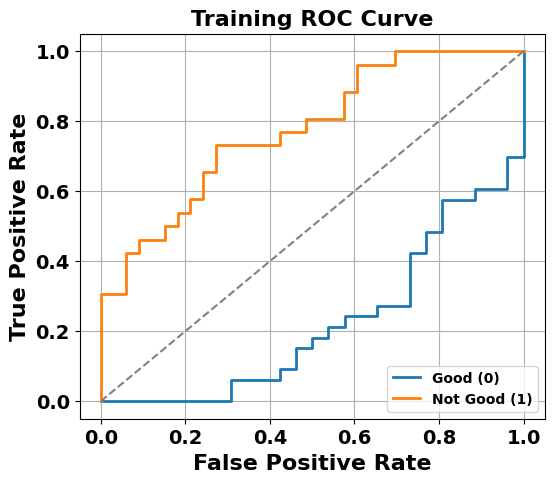

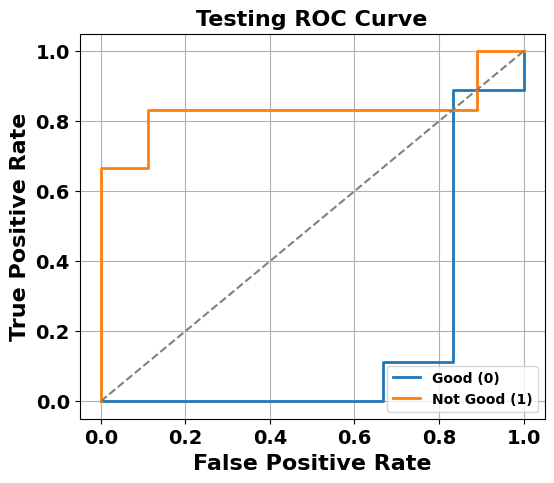

In [5]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Plot ROC for Training Data
plt.figure(figsize=(6, 5))
for i, label in enumerate(['Good (0)', 'Not Good (1)']):
    fpr, tpr, _ = roc_curve((train_patient_report['actual_class'] == i).astype(int),
                            train_patient_report['avg_probability'])
    plt.plot(fpr, tpr, linewidth=2, label=f'{label}')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate', fontsize=16, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=16, fontweight='bold')
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=14, prop={'weight': 'bold'})
plt.title('Training ROC Curve', fontsize=16, fontweight='bold')
plt.grid(True)
plt.show()

# Plot ROC for Testing Data
plt.figure(figsize=(6, 5))
for i, label in enumerate(['Good (0)', 'Not Good (1)']):
    fpr, tpr, _ = roc_curve((test_patient_report['actual_class'] == i).astype(int),
                            test_patient_report['avg_probability'])
    plt.plot(fpr, tpr, linewidth=2, label=f'{label}')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate', fontsize=16, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=16, fontweight='bold')
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=14, prop={'weight': 'bold'})
plt.title('Testing ROC Curve', fontsize=16, fontweight='bold')
plt.grid(True)
plt.show()


# Cross validation

In [ ]:
"""from sklearn.model_selection import StratifiedKFold
import torch
import numpy as np
import pandas as pd
from torch_geometric.loader import DataLoader
from tqdm import trange

# Assumes dataframe is already filtered (walking_speed == "Fast", QoR_class in [0,1])
patient_meta = dataframe[['patientID', 'QoR_class']].dropna().drop_duplicates()
# Extract patient IDs and labels
patient_ids = patient_meta['patientID'].values
patient_labels = patient_meta['QoR_class'].values.astype(int)

n_splits = 10
epoch_per_fold = 100
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)


from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, confusion_matrix
from tqdm import tqdm

fold_results = []



class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.005):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.best_model = None

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model = model.state_dict()
        else:
            self.counter += 1
            if self.counter >= self.patience:
                if self.best_model is not None:
                    model.load_state_dict(self.best_model)
                return True
        return False


for fold, (train_idx, val_idx) in enumerate(skf.split(patient_ids, patient_labels), 1):
    print(f"\nFold {fold}/{n_splits}")

    train_pids = patient_ids[train_idx]
    val_pids = patient_ids[val_idx]

    df_train = dataframe[dataframe['patientID'].isin(train_pids)].reset_index(drop=True)
    df_val = dataframe[dataframe['patientID'].isin(val_pids)].reset_index(drop=True)

    # Dataset and Dataloaders
    train_dataset = SkeletonDataset(df_train)
    val_dataset = SkeletonDataset(df_val)

    class_counts = df_train['QoR_class'].value_counts().sort_index().to_numpy()
    class_weights = 1. / class_counts
    sample_weights = [class_weights[int(label)] for label in df_train['QoR_class']]
    sampler = torch.utils.data.WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

    train_loader = DataLoader(train_dataset, batch_size=8, sampler=sampler)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

    # Model
    model = HybridSTGCN(in_channels=4, hidden_channels=128, num_classes=1).to(device)
    pos_weight = torch.tensor([class_weights[0] / class_weights[1]]).to(device)
    criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-4)
    early_stopping = EarlyStopping()

    # Training
    for epoch in trange(1, epoch_per_fold + 1, desc=f"Fold {fold}", leave=False):
        model.train()
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data)
            loss = criterion(out, data.y.float())
            loss.backward()
            optimizer.step()

        # Evaluation
        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for data in val_loader:
                data = data.to(device)
                out = model(data)
                preds = (torch.sigmoid(out) >= 0.5).float().view(-1).cpu().numpy()
                labels = data.y.view(-1).cpu().numpy()
                all_preds.extend(preds)
                all_labels.extend(labels)

        # Early stopping check
        val_loss = criterion(torch.tensor(all_preds, dtype=torch.float32, device=device),
                            torch.tensor(all_labels, dtype=torch.float32, device=device)
                            ).item()
        if early_stopping(val_loss, model):
            print(f"Early stopping triggered on epoch {epoch}")
            break

    # Metrics
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_preds)
    tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
    specificity = tn / (tn + fp)

    print(f"Fold {fold} | Accuracy: {acc:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")
    fold_results.append({
        'fold': fold,
        'accuracy': acc,
        'f1_score': f1,
        'recall': recall,
        'precision': precision,
        'specificity': specificity,
        'auc_roc': auc
    })

"""



Fold 1/10


Early stopping triggered on epoch 20
Fold 1 | Accuracy: 0.4439, F1: 0.3679, AUC: 0.4450

Fold 2/10


Early stopping triggered on epoch 18
Fold 2 | Accuracy: 0.2941, F1: 0.3171, AUC: 0.2932

Fold 3/10


ValueError: Target size (torch.Size([1])) must be the same as input size (torch.Size([]))

# Grad Cam

In [20]:
import torch
import numpy as np

class GradCAM_GNN:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        self._register_hooks()


    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        # Use ONLY regular hooks for compatibility with GCNConv
        self.hook_handles.append(self.target_layer.register_forward_hook(forward_hook))
        self.hook_handles.append(self.target_layer.register_backward_hook(backward_hook))


    def generate_cam(self, data):
        self.model.train()  # Required for LSTM backward with cuDNN

        # Forward pass
        output = self.model(data)
        
        # Backward pass
        self.model.zero_grad()
        output.backward(retain_graph=True)

        # Compute Grad-CAM
        cam = self.gradients * self.activations  # Shape: [num_nodes, hidden_channels]
        node_cam = cam.mean(dim=-1).squeeze()    # Mean over channels → [num_nodes]

        # Normalize to [0, 1]
        node_cam = node_cam - node_cam.min()
        node_cam = node_cam / (node_cam.max() + 1e-6)

        # Edge-wise CAM based on average of connected node CAMs
        edge_index = data.edge_index.cpu().numpy()
        edge_cam = []
        for i in range(edge_index.shape[1]):
            src, dst = edge_index[:, i]
            edge_imp = (node_cam[src] + node_cam[dst]) / 2.0
            edge_cam.append(edge_imp.item())
        edge_cam = np.array(edge_cam)

        return node_cam.detach().cpu().numpy(), edge_cam

    def remove_hooks(self):
        for handle in self.hook_handles:
            handle.remove()


import plotly.graph_objs as go
from plotly.subplots import make_subplots
import numpy as np

def visualize_human_skeleton_3d_plotly(cam, data, title="3D Grad-CAM Visualization"):
    node_cam, edge_cam = cam
    node_positions = data.x[:, :3].cpu().numpy()  # X, Y, Z from node features

    # Node scatter plot
    scatter = go.Scatter3d(
        x=node_positions[:, 0],
        y=node_positions[:, 1],
        z=node_positions[:, 2],
        mode='markers+text',
        text=[f'{i}' for i in range(len(node_positions))],
        marker=dict(
            size=8,
            color=node_cam,
            colorscale='Viridis',
            colorbar=dict(title="Node CAM", x=0.9),
            opacity=0.8
        )
    )

    # Edge lines
    edge_index = data.edge_index.cpu().numpy()
    edge_x, edge_y, edge_z, edge_colors = [], [], [], []
    for i in range(edge_index.shape[1]):
        src, dst = edge_index[:, i]
        edge_x += [node_positions[src, 0], node_positions[dst, 0], None]
        edge_y += [node_positions[src, 1], node_positions[dst, 1], None]
        edge_z += [node_positions[src, 2], node_positions[dst, 2], None]
        edge_colors += [edge_cam[i], edge_cam[i], edge_cam[i]]

    lines = go.Scatter3d(
        x=edge_x, y=edge_y, z=edge_z,
        mode='lines',
        line=dict(
            color=edge_colors,
            colorscale='Viridis',
            width=4,
            colorbar=dict(title="Edge CAM", x=1.05)
        ),
        hoverinfo='none'
    )

    # Combine all
    fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'scatter3d'}]])
    fig.add_trace(scatter)
    fig.add_trace(lines)

    fig.update_layout(
        title=title,
        scene=dict(
            xaxis=dict(showgrid=False, showticklabels=False),
            yaxis=dict(showgrid=False, showticklabels=False),
            zaxis=dict(showgrid=False, showticklabels=False),
            aspectmode='cube',
            bgcolor='white'
        ),
        paper_bgcolor='white',
        margin=dict(l=0, r=0, t=40, b=0)
    )

    fig.show()



# Replace with your actual file
data_path = r"D:\Data\NYC\KINZ\KINECT_ACC_dataset_with_qor15_2025-05-27_14-29PM.csv"
dataframe = pd.read_csv(data_path)
dataframe = dataframe[dataframe['walking_speed'] == "Fast"]
dataframe.rename(columns={'PatientID': 'patientID'}, inplace=True)

from torch_geometric.data import DataLoader

# Load patient
patient_id = '047-MW'
patient_data = dataframe[dataframe['patientID'] == patient_id].reset_index(drop=True)
patient_dataset = SkeletonDataset(patient_data)
patient_loader = DataLoader(patient_dataset, batch_size=1, shuffle=False)

# Define target GCN layer
target_layer = model.gcn2
grad_cam = GradCAM_GNN(model, target_layer)

# Pick specific frame(s)
points_to_plot = [56]  # or [0, 30, 60, ...]

for i, single_sample in enumerate(patient_loader):
    if i in points_to_plot:
        print(f"Visualizing Grad-CAM for patient {patient_id}, frame {i}")
        single_sample = single_sample.to(device)
        cam = grad_cam.generate_cam(single_sample)
        visualize_human_skeleton_3d_plotly(cam, single_sample, title=f"Patient {patient_id} - Frame {i}")

grad_cam.remove_hooks()



C:\Users\user\AppData\Local\Temp\ipykernel_3472\4228477498.py:130: DtypeWarning:

Columns (108,112,113,117,151,154,161,162,164,169,180,185,198,221,228,264,267,269,270,306,307,310,311,314,315,318,319,322,323,326,328,330,331,334,335,338,339,342,343,346,348,350,352,354,356,358,362,363,393,403,404,406,418,423,430,433,436,439,444) have mixed types. Specify dtype option on import or set low_memory=False.



Visualizing Grad-CAM for patient 047-MW, frame 56


c:\Users\user\miniconda3\envs\torch_on\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning:

'data.DataLoader' is deprecated, use 'loader.DataLoader' instead

c:\Users\user\miniconda3\envs\torch_on\lib\site-packages\torch\nn\modules\module.py:1830: FutureWarning:

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.

